## Notebook para la exploración de los ficheros de datos del TFM
### Script para la exploración de los datasets para el TFM: Optimización de la toma de decisiones empresarial
### mediante el análisis de datos

## EXPLORACIÓN DE LOS DATOS Y PREPROCESAMIENTO

### Carga de los ficheros y exploración de las variables

In [95]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
# Lectura de los .CSV y convertimos los tipos automáticamente
df = pd.read_csv('C:/Users/UX530/Desktop/TFM-GIT/Origin_Files/extended_cto_2025-09-30_09_35.csv', delimiter = ';')

In [97]:
# Número de filas y columnas
print("Número de filas y columnas:", df.shape)
# Nombre de las columnas
print("Nombres de las columnas:", df.columns.tolist())
# Tipo de datos de cada columna
print("Tipos de datos:\n", df.dtypes)
# Información general del DataFrame
print("Información del DataFrame:" , df.info())
# Cabecera del DataFrame
print("Cabecera del dataframe:", df.head())

Número de filas y columnas: (11505, 28)
Nombres de las columnas: ['ID', 'CTO', 'Código CTO', 'Estado', 'Tipo de ampliación', 'Ticket Jira', 'EC', 'Fecha de solicitud', 'Fecha de ejecución', 'Fecha de documentación', 'Fecha de parada', 'Fecha de reanudación', 'Fecha Documentación Rechazada', 'Fecha  Documentación Reparada', 'Fecha de finalización', 'Fecha Cancelación', 'SLA', 'Geotipo', 'Nueva CTO', 'Rechazos (iteraciones)', 'Provincia', 'Población', 'Zona', 'Fase', 'Cluster', 'Proveedor OLT', 'Observaciones', 'Activo']
Tipos de datos:
 ID                                 int64
CTO                               object
Código CTO                        object
Estado                            object
Tipo de ampliación                object
Ticket Jira                       object
EC                                object
Fecha de solicitud                object
Fecha de ejecución                object
Fecha de documentación            object
Fecha de parada                   object
Fecha d

### Se hará una copia del dataframen original

In [98]:
df_CTO = df.copy()  # Se hará una copia del dataframen original

#### Columnas de los datasets candidatas para dejar fuera del modelo por tener más de un 60% de nulos

In [99]:
# Calacula el porcentaje de valores nulos en cada columna, y nos quedamos con las que tienen más del 60%
# serán columnas candidatas a eliminar del modelo. 
Columns_delete_CTO = (df_CTO.isnull().mean() * 100)[df_CTO.isnull().mean() * 100 > 60].index.tolist()
Columns_delete_CTO

['Ticket Jira',
 'Fecha de parada',
 'Fecha de reanudación',
 'Fecha Documentación Rechazada',
 'Fecha  Documentación Reparada',
 'Fecha Cancelación',
 'Nueva CTO',
 'Rechazos (iteraciones)',
 'Observaciones']

In [100]:
# Elimanamos las columnas con más del 60% de valores nulos y nos quedamos con el nuevo dataframe
df_CTO_cleaned = df_CTO.drop(columns=Columns_delete_CTO)

### Vamos a transformar las variables fechas que están en tipo object al formato datatime

In [101]:
df_CTO_cleaned["Fecha de ejecución"] = pd.to_datetime(df_CTO_cleaned["Fecha de ejecución"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
df_CTO_cleaned['Fecha de ejecución']

0       2019-03-28 09:26:11
1                       NaT
2       2019-02-15 12:50:03
3                       NaT
4       2019-02-15 13:09:21
                ...        
11500                   NaT
11501                   NaT
11502                   NaT
11503                   NaT
11504                   NaT
Name: Fecha de ejecución, Length: 11505, dtype: datetime64[ns]

In [102]:
# Columnas con información de fechas relevantes para el análisis
Columns_date = ['Fecha de solicitud','Fecha de documentación', 'Fecha de finalización']

# Transformamos las variables fechas que están en tipo object al formato datatime
for col in Columns_date:
    try:
        df_CTO_cleaned[col] = pd.to_datetime(df_CTO_cleaned[col], errors='coerce', format='%Y-%m-%d')
    except (ValueError, TypeError):
        pass  

# Verificamos la conversión
df_CTO_cleaned.dtypes

ID                                 int64
CTO                               object
Código CTO                        object
Estado                            object
Tipo de ampliación                object
EC                                object
Fecha de solicitud        datetime64[ns]
Fecha de ejecución        datetime64[ns]
Fecha de documentación    datetime64[ns]
Fecha de finalización     datetime64[ns]
SLA                               object
Geotipo                           object
Provincia                         object
Población                         object
Zona                             float64
Fase                              object
Cluster                           object
Proveedor OLT                     object
Activo                            object
dtype: object

### El resto de nulos de nuestros variables numércias vamos a rellenarlos con la función interpolate()
### Para las variables categícas vamos a utilizar el valor de la moda, el dato que más se repita.

In [103]:
# Interpolación de los valores nulos en las columnas numéricas
df_CTO_cleaned_interpolated = df_CTO_cleaned.interpolate(method='linear', limit_direction='both')

C:\Users\UX530\AppData\Local\Temp\ipykernel_2784\1345398727.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_CTO_cleaned_interpolated = df_CTO_cleaned.interpolate(method='linear', limit_direction='both')


In [104]:
# Interpolación de los valores nulos en las columnas categóricas con el método de la moda
for col in df_CTO_cleaned_interpolated.select_dtypes(include=['object']).columns:
    mode_value = df_CTO_cleaned_interpolated[col].mode()[0]
    df_CTO_cleaned_interpolated[col].fillna(mode_value, inplace=True)

C:\Users\UX530\AppData\Local\Temp\ipykernel_2784\3646763603.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_CTO_cleaned_interpolated[col].fillna(mode_value, inplace=True)


In [105]:
# Comprobamos que no quedan nulos
total_rows = len(df_CTO_cleaned_interpolated)
null_summary = df_CTO_cleaned_interpolated.isna().sum().to_frame("Nulos")
null_summary["% Nulos"] = (null_summary["Nulos"] / total_rows) * 100
print(null_summary)

                        Nulos  % Nulos
ID                          0      0.0
CTO                         0      0.0
Código CTO                  0      0.0
Estado                      0      0.0
Tipo de ampliación          0      0.0
EC                          0      0.0
Fecha de solicitud          0      0.0
Fecha de ejecución          0      0.0
Fecha de documentación      0      0.0
Fecha de finalización       0      0.0
SLA                         0      0.0
Geotipo                     0      0.0
Provincia                   0      0.0
Población                   0      0.0
Zona                        0      0.0
Fase                        0      0.0
Cluster                     0      0.0
Proveedor OLT               0      0.0
Activo                      0      0.0


## OPCIÓN I: Modelo sin Provincias.

### Objetivo de estudio: Queremos predecir el número de ampliaciones por semana que surgirán en la segunda mitad del año.
### Vamos a calcular nuestra serie temporal que abarcará las amplaciones surgidas por semana/año

In [106]:
# Creamos nuestra serie temporal semanal en un dataframe nuevo
df_CTO_weekly = df_CTO_cleaned_interpolated.set_index('Fecha de solicitud').resample('W').size().reset_index(name='Número de ampliaciones')
df_CTO_weekly.head()

,Fecha de solicitud,Número de ampliaciones
0,2019-01-20,104
1,2019-01-27,3
2,2019-02-03,63
3,2019-02-10,23
4,2019-02-17,417


In [107]:
# Tenemos que distinguir por año el número de semana, no todos los años ha habido el mismo número de amplaciones
df_CTO_weekly['Año'] = df_CTO_weekly['Fecha de solicitud'].dt.year
df_CTO_weekly['Semana'] = df_CTO_weekly['Fecha de solicitud'].dt.isocalendar().week
df_CTO_weekly.head()

,Fecha de solicitud,Número de ampliaciones,Año,Semana
0,2019-01-20,104,2019,3
1,2019-01-27,3,2019,4
2,2019-02-03,63,2019,5
3,2019-02-10,23,2019,6
4,2019-02-17,417,2019,7


In [108]:
# Generamos un solo identificador por año y semana
df_CTO_weekly['Año-Semana'] = df_CTO_weekly['Año'].astype(str) + '-W' + df_CTO_weekly['Semana'].astype(str)
df_CTO_weekly.head()

,Fecha de solicitud,Número de ampliaciones,Año,Semana,Año-Semana
0,2019-01-20,104,2019,3,2019-W3
1,2019-01-27,3,2019,4,2019-W4
2,2019-02-03,63,2019,5,2019-W5
3,2019-02-10,23,2019,6,2019-W6
4,2019-02-17,417,2019,7,2019-W7


### Vamos analizar las características con alguna visualización para la detección de outliers, tendencia o estacionalidad

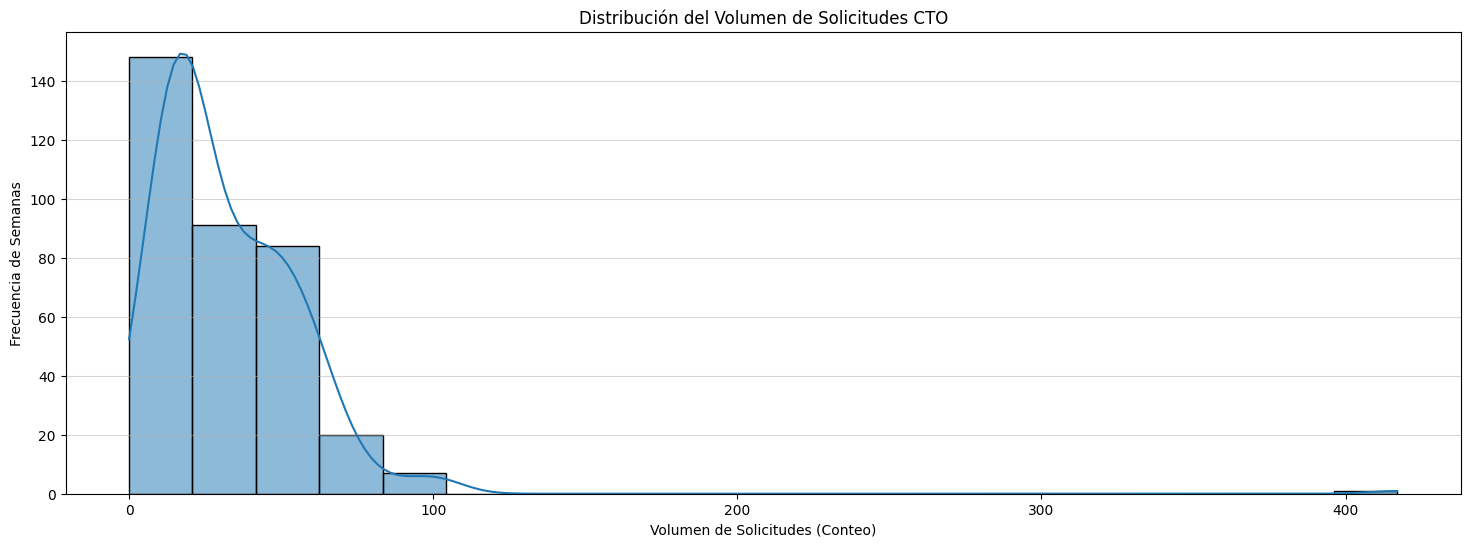

In [109]:
# Análisis exploratorio de datos (EDA)
# Visualización de la serie temporal: HISDTOGRAMA de la Variable Objetivo
plt.figure(figsize=(18, 6))
sns.histplot(df_CTO_weekly['Número de ampliaciones'], bins=20, kde=True)
plt.title('Distribución del Volumen de Solicitudes CTO')
plt.xlabel('Volumen de Solicitudes (Conteo)')
plt.ylabel('Frecuencia de Semanas')
plt.grid(axis='y', alpha=0.5)
plt.show()

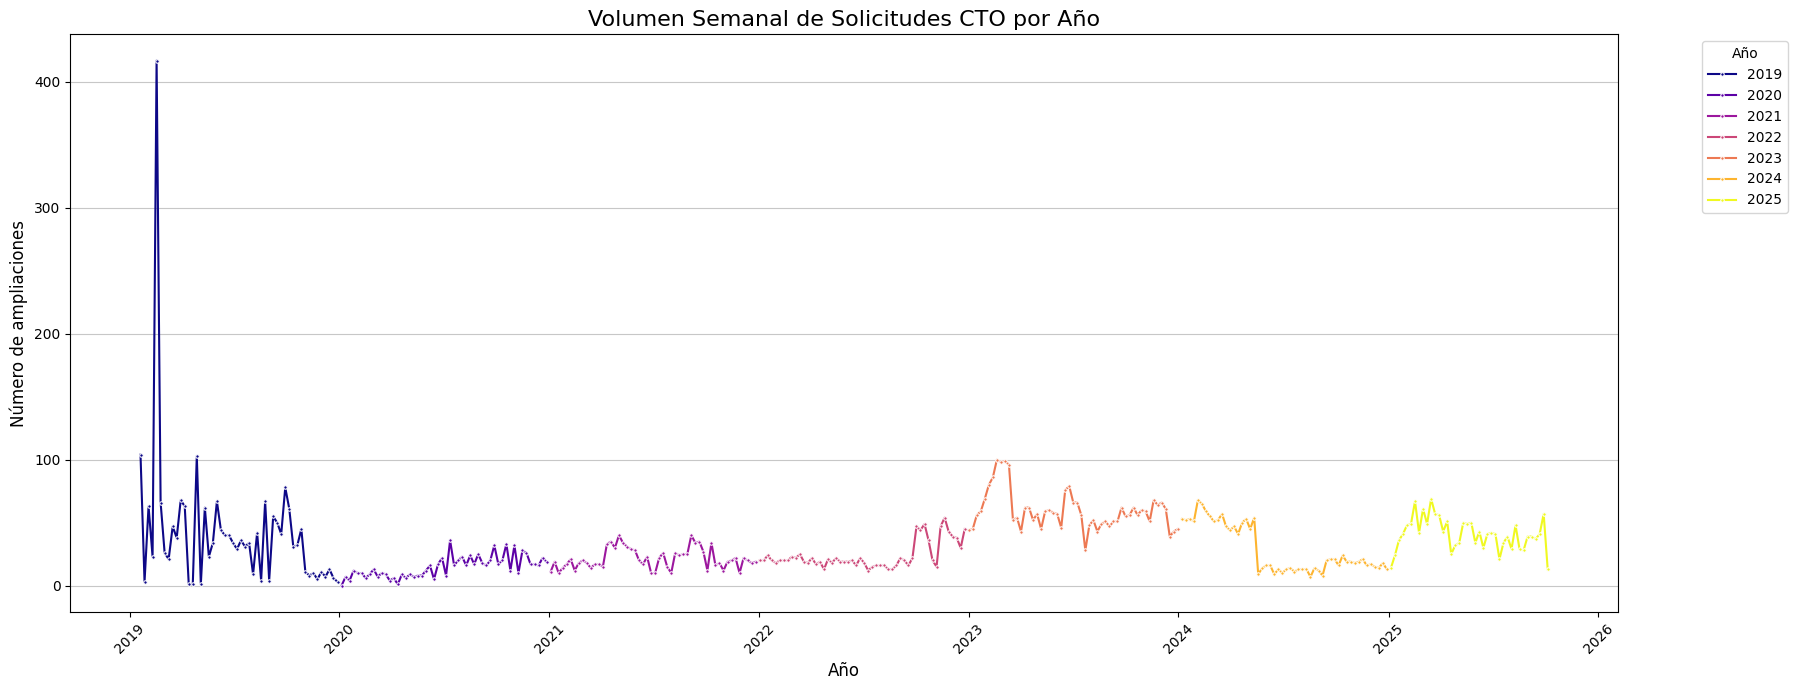

In [110]:
# Visualización de la serie temporal: LINEA DE TIEMPO AGREGADA
plt.figure(figsize=(18, 7))
# La función reset_index() es necesaria para que 'Fecha de solicitud' sea una columna y no el índice
sns.lineplot(
    data=df_CTO_weekly.reset_index(), # Convertimos el índice a columna para seaborn
    x='Fecha de solicitud',
    y='Número de ampliaciones',
    hue='Año',                         # ¡Aquí es donde mapeamos el color al año!
    marker='.',                        # Pequeños puntos en cada observación
    linestyle='-',                     # Línea continua
    palette='plasma',                 # Paleta de colores (puedes probar 'plasma', 'cividis', 'magma', 'coolwarm')
    linewidth=1.5,
    markersize=5
)

plt.title('Volumen Semanal de Solicitudes CTO por Año', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de ampliaciones', fontsize=12)
plt.grid(axis='y', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left') # Mover la leyenda para no superponer
plt.tight_layout() # Ajustar el diseño para que la leyenda no se corte
plt.show()

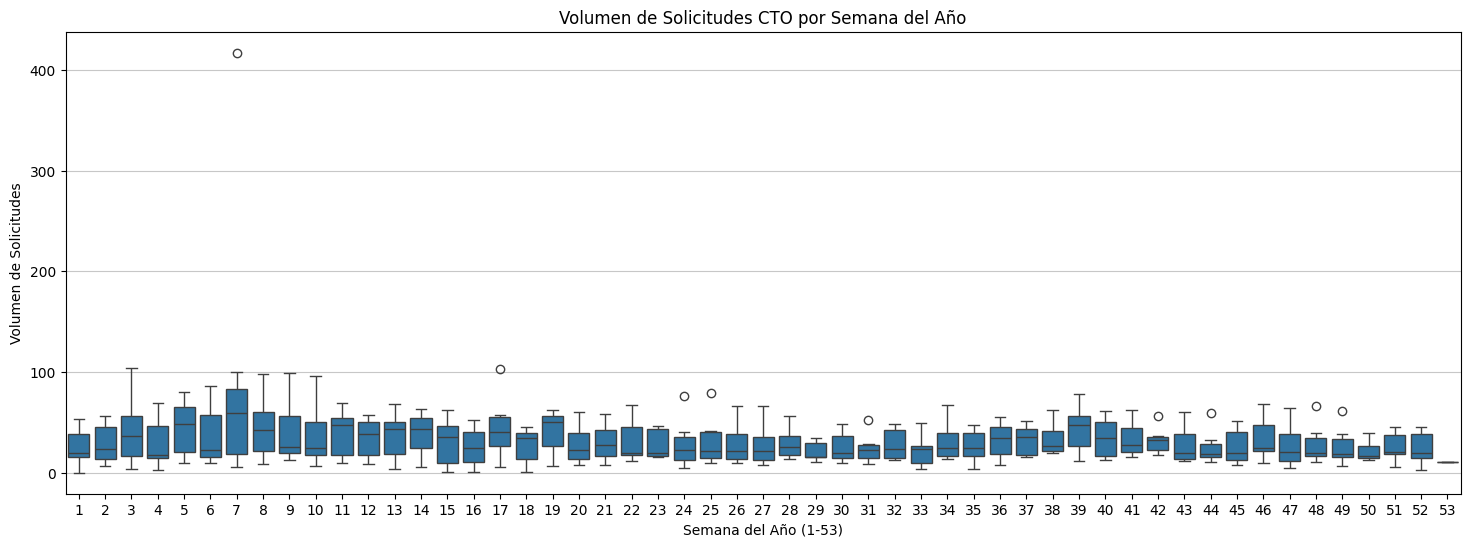

In [111]:
# Visualización de la serie temporal: BOXPLOT por año
plt.figure(figsize=(18, 6))
sns.boxplot(x='Semana', y='Número de ampliaciones', data=df_CTO_weekly.reset_index())
plt.title('Volumen de Solicitudes CTO por Semana del Año')
plt.xlabel('Semana del Año (1-53)')
plt.ylabel('Volumen de Solicitudes')
plt.grid(axis='y', alpha=0.7)
plt.show()

### Analizando las trés gráficas, hemos detectado un outlier en W7 del 2019, con más de 400 solicitudes
### al ser un evento especial e irrepetible, procedemos a eliminarlo de nuestro modelo.

In [112]:
df_CTO_weekly.head(20) , df_CTO_weekly.tail(20)

(   Fecha de solicitud  Número de ampliaciones   Año  Semana Año-Semana
 0          2019-01-20                     104  2019       3    2019-W3
 1          2019-01-27                       3  2019       4    2019-W4
 2          2019-02-03                      63  2019       5    2019-W5
 3          2019-02-10                      23  2019       6    2019-W6
 4          2019-02-17                     417  2019       7    2019-W7
 5          2019-02-24                      66  2019       8    2019-W8
 6          2019-03-03                      26  2019       9    2019-W9
 7          2019-03-10                      21  2019      10   2019-W10
 8          2019-03-17                      47  2019      11   2019-W11
 9          2019-03-24                      38  2019      12   2019-W12
 10         2019-03-31                      68  2019      13   2019-W13
 11         2019-04-07                      63  2019      14   2019-W14
 12         2019-04-14                       1  2019      15   2

In [113]:
# Eliminamos la semana 7 del año 2019 que es un outlier
df_CTO_weekly = df_CTO_weekly.drop(df_CTO_weekly[(df_CTO_weekly['Año'] == 2019) & (df_CTO_weekly['Semana'] == 7)].index)
df_CTO_weekly.head(20) , df_CTO_weekly.tail(20)

(   Fecha de solicitud  Número de ampliaciones   Año  Semana Año-Semana
 0          2019-01-20                     104  2019       3    2019-W3
 1          2019-01-27                       3  2019       4    2019-W4
 2          2019-02-03                      63  2019       5    2019-W5
 3          2019-02-10                      23  2019       6    2019-W6
 5          2019-02-24                      66  2019       8    2019-W8
 6          2019-03-03                      26  2019       9    2019-W9
 7          2019-03-10                      21  2019      10   2019-W10
 8          2019-03-17                      47  2019      11   2019-W11
 9          2019-03-24                      38  2019      12   2019-W12
 10         2019-03-31                      68  2019      13   2019-W13
 11         2019-04-07                      63  2019      14   2019-W14
 12         2019-04-14                       1  2019      15   2019-W15
 13         2019-04-21                       1  2019      16   2

### Aplicamos la descomposición aditiva para anlizar todas las componentes, tendencia, estacionariedad y residuos.

In [114]:
# Aplicamos la descomposición seasonal_decompose para analizar los componentes de la serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose
ts = df_CTO_weekly['Número de ampliaciones']
try:
    decomposition = seasonal_decompose(
        ts, 
        model='additive', 
        period=52 
    )
    print("Descomposición completada exitosamente.")
    
except ValueError as e:
    # Este error ocurre si la serie no tiene suficientes puntos (al menos dos ciclos completos)
    print(f"Error al aplicar period=52: {e}")
    print("Intentando con un período más corto (ej. period=4 para estacionalidad mensual aproximada).")
    decomposition = seasonal_decompose(
        ts, 
        model='additive',
        period=4
    )
    print("Descomposición completada con un período de 4.")


Descomposición completada exitosamente.


#### Aplicamos la autocorrelación de los residuos, donde vemos que tenemos aún valores fuera de la banda de confianza, estos valores
#### pueden ser candidatos a declararse como outliers. Lo podemos observar con el gráfico de la linea temporal de los residuos.

<Figure size 1600x600 with 0 Axes>

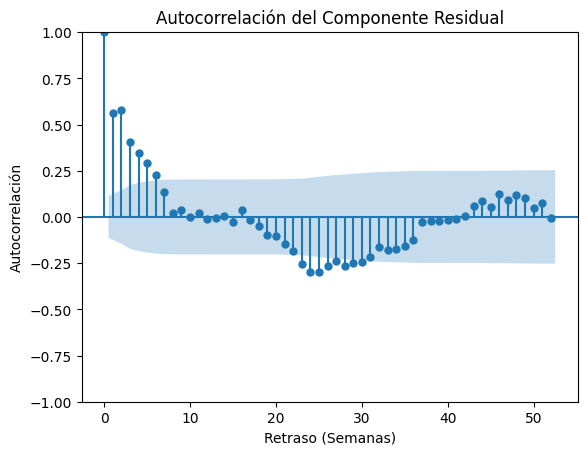

In [115]:
# Gráfico de autocorrelación de los residuos
from statsmodels.graphics.tsaplots import plot_acf
# 1. Extraer el componente residual
residuales = decomposition.resid.dropna()

# 2. Generar el Gráfico de Autocorrelación
plt.figure(figsize=(16, 6))
plot_acf(
    residuales, 
    lags=52,  # Mostrar hasta 52 retrasos (un año completo de semanas)
    title='Autocorrelación del Componente Residual'
)
plt.xlabel('Retraso (Semanas)')
plt.ylabel('Autocorrelación')
plt.show()

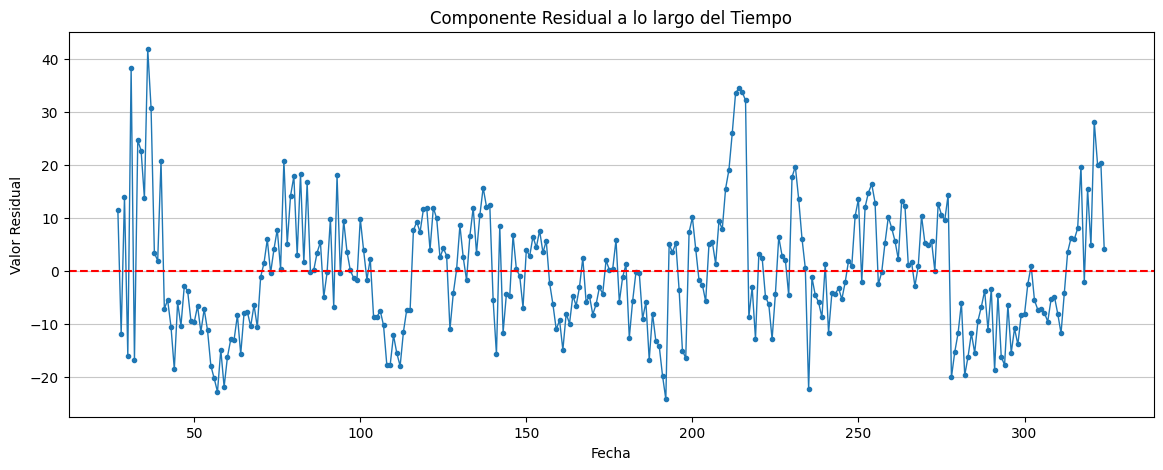

In [116]:
plt.figure(figsize=(14, 5))
plt.plot(residuales.index, residuales, marker='o', linestyle='-', markersize=3, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--') # Línea de referencia en cero
plt.title('Componente Residual a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Residual')
plt.grid(axis='y', alpha=0.7)
plt.show()

## OPCIÓN II: Modelo incluyendo las provincias.

In [117]:
df_limpio = df_CTO_cleaned_interpolated.dropna(subset=['Fecha de solicitud', 'Provincia'])
df_limpio.head()

,ID,CTO,Código CTO,Estado,Tipo de ampliación,EC,Fecha de solicitud,Fecha de ejecución,Fecha de documentación,Fecha de finalización,SLA,Geotipo,Provincia,Población,Zona,Fase,Cluster,Proveedor OLT,Activo
0,1,489-46-008078.2,48946-008078.02,FINALIZADA,PREVENTIVA-1,ELECNOR,2019-01-18,2019-03-28 09:26:11,2019-03-28 00:00:00,2019-09-25,69 (Max. 14),C,VALENCIA,ALBALAT DE LA RIBERA,3.0,2,489-46-008-004-CL,Masmovil,Sí
1,2,489-46-011192,48946-011192,CANCELADA,F07,ELECNOR,2019-01-18,2019-03-07 23:08:07,2019-03-16 12:00:00,2019-06-18,14 (Max. 7),"A,C",CASTELLON,ALMENARA,3.0,2,489-46-011-017-CL,Masmovil,Sí
2,3,489-46-011225,48946-011225,FINALIZADA,F07,ELECNOR,2019-02-01,2019-02-15 12:50:03,2019-03-05 00:00:00,2019-03-11,32 (Max. 7),A,VALENCIA,ALBERIC,3.0,2,489-46-011-004-CL,Masmovil,Sí
3,5,489-46-011118,48946-011118,CANCELADA,PREVENTIVA-1,ELECNOR,2019-01-18,2019-02-15 12:59:42,2019-03-05 00:00:00,2019-03-22,59 (Max. 14),"A,C",VALENCIA,ALBERIC,3.0,2,489-46-011-038-CL,Masmovil,Sí
4,6,489-46-011158.1,48946-011158.01,FINALIZADA,PREVENTIVA-1,ELECNOR,2019-01-18,2019-02-15 13:09:21,2019-03-05 00:00:00,2019-04-02,46 (Max. 14),"C,A",VALENCIA,ALBERIC,3.0,2,489-46-011-022-CL,Masmovil,Sí


In [118]:
# Agrupamos por semana y provincia, y contamos el número de ampliaciones
df_modelo = (
    df_limpio
    .groupby([pd.Grouper(key='Fecha de solicitud', freq='W'), 'Provincia'])
    .size()
    .reset_index(name='Numero_Ampliaciones')
)
df_modelo.head(10)

,Fecha de solicitud,Provincia,Numero_Ampliaciones
0,2019-01-20,ALBACETE,1
1,2019-01-20,CASTELLON,10
2,2019-01-20,CIUDAD REAL,24
3,2019-01-20,CUENCA,1
4,2019-01-20,GUADALAJARA,1
5,2019-01-20,LLEIDA,7
6,2019-01-20,MADRID,17
7,2019-01-20,SALAMANCA,4
8,2019-01-20,TOLEDO,25
9,2019-01-20,VALENCIA,14


In [119]:
# Incluimos columnas de año, número de semana y un identificador único año-semana
df_modelo['Año'] = df_modelo['Fecha de solicitud'].dt.isocalendar().year.astype(int)
df_modelo['Semana_del_Año'] = df_modelo['Fecha de solicitud'].dt.isocalendar().week.astype(int)
df_modelo['Semana_Año'] = df_modelo['Semana_Año'] = df_modelo['Año'].astype(str) + '-W' + df_modelo['Semana_del_Año'].astype(str).str.zfill(2) 
len(df_modelo), df_modelo.head(10), df_modelo.tail(10)


(3455,
   Fecha de solicitud    Provincia  Numero_Ampliaciones   Año  Semana_del_Año  \
 0         2019-01-20     ALBACETE                    1  2019               3   
 1         2019-01-20    CASTELLON                   10  2019               3   
 2         2019-01-20  CIUDAD REAL                   24  2019               3   
 3         2019-01-20       CUENCA                    1  2019               3   
 4         2019-01-20  GUADALAJARA                    1  2019               3   
 5         2019-01-20       LLEIDA                    7  2019               3   
 6         2019-01-20       MADRID                   17  2019               3   
 7         2019-01-20    SALAMANCA                    4  2019               3   
 8         2019-01-20       TOLEDO                   25  2019               3   
 9         2019-01-20     VALENCIA                   14  2019               3   
 
   Semana_Año  
 0   2019-W03  
 1   2019-W03  
 2   2019-W03  
 3   2019-W03  
 4   2019-W03  
 5  

### Visualización del dataset

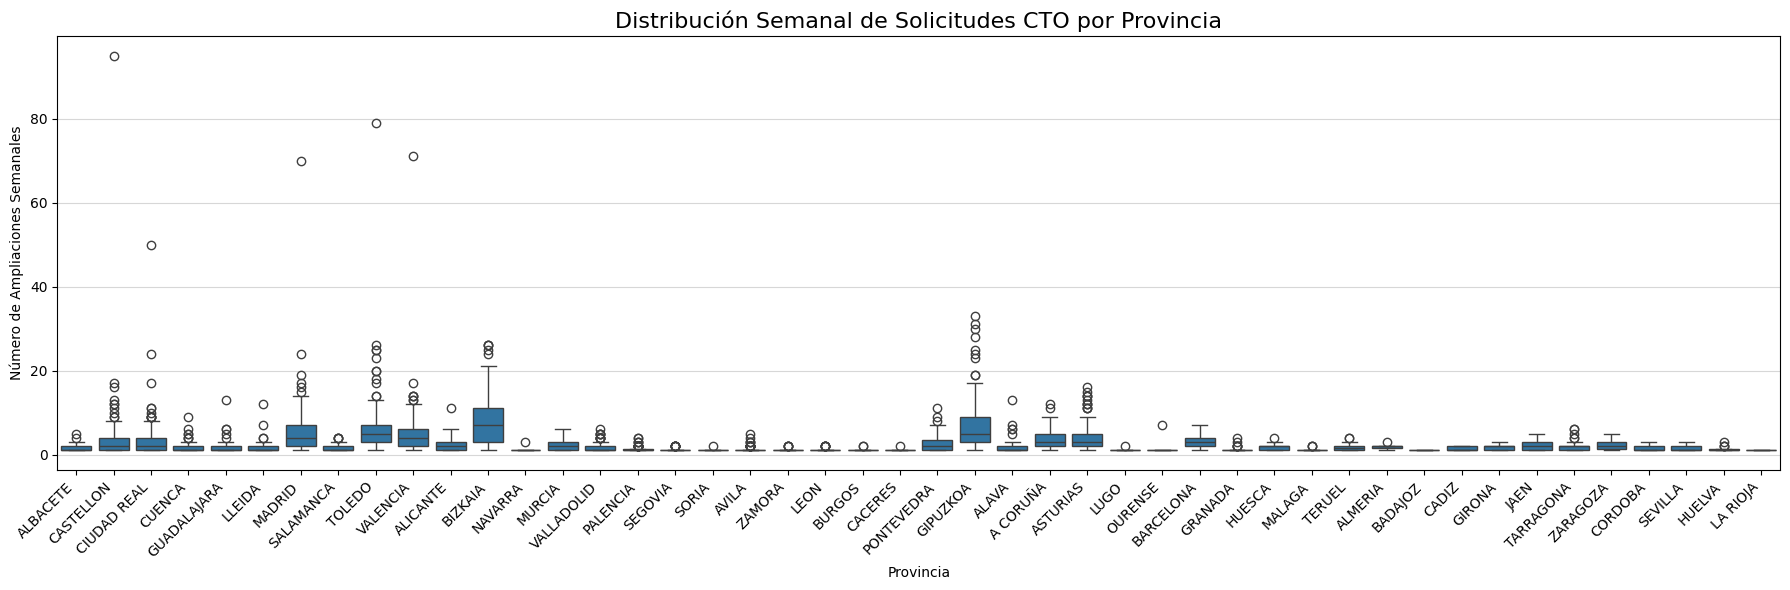

In [120]:
# Boxplot: vamos a ver si tenemos outliers en la variable objetivo por provincias
plt.figure(figsize=(18, 6))
sns.boxplot(x='Provincia', y='Numero_Ampliaciones', data=df_modelo)
plt.title('Distribución Semanal de Solicitudes CTO por Provincia', fontsize=16)
plt.xlabel('Provincia')
plt.ylabel('Número de Ampliaciones Semanales')
plt.xticks(rotation=45, ha='right') # Rota las etiquetas de las provincias para mejor lectura
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

### Variables categóricas a numéricas

In [121]:
# Creamos un id numérico para cada provincia
df_modelo['Provincia_ID'] = df_modelo['Provincia'].astype('category').cat.codes
df_modelo.head(5)

,Fecha de solicitud,Provincia,Numero_Ampliaciones,Año,Semana_del_Año,Semana_Año,Provincia_ID
0,2019-01-20,ALBACETE,1,2019,3,2019-W03,2
1,2019-01-20,CASTELLON,10,2019,3,2019-W03,13
2,2019-01-20,CIUDAD REAL,24,2019,3,2019-W03,14
3,2019-01-20,CUENCA,1,2019,3,2019-W03,16
4,2019-01-20,GUADALAJARA,1,2019,3,2019-W03,20


In [122]:
df_modelo['Provincia_ID'].dtypes

dtype('int8')

In [123]:
df_modelo['Provincia_ID'].head()

0     2
1    13
2    14
3    16
4    20
Name: Provincia_ID, dtype: int8

In [124]:
# Utilizamos la técnica de one-hot encoding para convertir la variable categórica 'Provincia' en variables dummy y evitar que se pueda interpretar un orden entre ellas
df_provincias_encoded  = pd.get_dummies(df_modelo, columns=['Provincia'], prefix='Provincia')
df_modelo = pd.concat([df_modelo, df_provincias_encoded], axis=1)
df_modelo.head(5)

,Fecha de solicitud,Provincia,Numero_Ampliaciones,Año,Semana_del_Año,Semana_Año,Provincia_ID,Fecha de solicitud,Numero_Ampliaciones,Año,...,Provincia_SEGOVIA,Provincia_SEVILLA,Provincia_SORIA,Provincia_TARRAGONA,Provincia_TERUEL,Provincia_TOLEDO,Provincia_VALENCIA,Provincia_VALLADOLID,Provincia_ZAMORA,Provincia_ZARAGOZA
0,2019-01-20,ALBACETE,1,2019,3,2019-W03,2,2019-01-20,1,2019,...,False,False,False,False,False,False,False,False,False,False
1,2019-01-20,CASTELLON,10,2019,3,2019-W03,13,2019-01-20,10,2019,...,False,False,False,False,False,False,False,False,False,False
2,2019-01-20,CIUDAD REAL,24,2019,3,2019-W03,14,2019-01-20,24,2019,...,False,False,False,False,False,False,False,False,False,False
3,2019-01-20,CUENCA,1,2019,3,2019-W03,16,2019-01-20,1,2019,...,False,False,False,False,False,False,False,False,False,False
4,2019-01-20,GUADALAJARA,1,2019,3,2019-W03,20,2019-01-20,1,2019,...,False,False,False,False,False,False,False,False,False,False


In [125]:
# Eliminamos la columna de texto original 'Provincia'
df_modelo = df_modelo.drop('Provincia', axis=1)

In [126]:
print("\n--- 2. Estructura después de One-Hot Encoding ---")
print(df_modelo.head())


--- 2. Estructura después de One-Hot Encoding ---
  Fecha de solicitud  Numero_Ampliaciones   Año  Semana_del_Año Semana_Año  \
0         2019-01-20                    1  2019               3   2019-W03   
1         2019-01-20                   10  2019               3   2019-W03   
2         2019-01-20                   24  2019               3   2019-W03   
3         2019-01-20                    1  2019               3   2019-W03   
4         2019-01-20                    1  2019               3   2019-W03   

   Provincia_ID Fecha de solicitud  Numero_Ampliaciones   Año  Semana_del_Año  \
0             2         2019-01-20                    1  2019               3   
1            13         2019-01-20                   10  2019               3   
2            14         2019-01-20                   24  2019               3   
3            16         2019-01-20                    1  2019               3   
4            20         2019-01-20                    1  2019              

### Creamos las variables de memoria temporal

In [127]:
# Creamos las variables de memoria temporal
TARGET = 'Numero_Ampliaciones'
lags_a_crear = [1, 4, 52] 

In [128]:
df_modelo['Provincia_ID'].head()

,Provincia_ID,Provincia_ID
0,2,2
1,13,13
2,14,14
3,16,16
4,20,20


In [129]:
df_modelo = df_modelo.loc[:, ~df_modelo.columns.duplicated()]

In [130]:
df_modelo['Provincia_ID'].head()

0     2
1    13
2    14
3    16
4    20
Name: Provincia_ID, dtype: int8

In [131]:
for lag in lags_a_crear:
    nueva_columna = f'{TARGET}_L{lag}'
    
    # El groupby() ahora debería funcionar sin problemas
    df_modelo[nueva_columna] = (
        df_modelo
        .groupby('Provincia_ID')[TARGET]
        .shift(lag)
    )

In [132]:
# Eliminamos las filas incompletas
df_modelo_final = df_modelo.dropna(subset=[f'{TARGET}_L{lags_a_crear[-1]}'])

print("\n--- ¡Paso 3 Exitoso! Estructura Final con Lags ---")
print(df_modelo_final.head())


--- ¡Paso 3 Exitoso! Estructura Final con Lags ---
    Fecha de solicitud  Numero_Ampliaciones   Año  Semana_del_Año Semana_Año  \
410         2020-03-08                    2  2020              10   2020-W10   
416         2020-03-15                    2  2020              11   2020-W11   
417         2020-03-22                    3  2020              12   2020-W12   
420         2020-03-22                    3  2020              12   2020-W12   
422         2020-03-29                    2  2020              13   2020-W13   

     Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  Provincia_ALBACETE  \
410            41               False            False               False   
416            41               False            False               False   
417            14               False            False               False   
420            41               False            False               False   
422            28               False            False               False   

## MODELOS DE PREDICCIÓN: LightGBM y Función de coste


In [133]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import pandas as pd

### Escogemos el conjunto de entrenamiento, para ello es necesario poner una fecha de corte. A partir de esta fecha se realizará la predicción.

In [134]:
# Definimos la fecha de corte: el final de la Semana 39 de 2025
# Usamos '2025-09-28' como la fecha de fin de la W39
fecha_corte = pd.to_datetime('2025-09-28')

In [135]:
# Conjunto de Entrenamiento (Train): Datos hasta la W39 2025
df_train = df_modelo_final[df_modelo_final['Fecha de solicitud'] <= fecha_corte].copy()


In [136]:
df_train.head() , df_train.tail()

(    Fecha de solicitud  Numero_Ampliaciones   Año  Semana_del_Año Semana_Año  \
 410         2020-03-08                    2  2020              10   2020-W10   
 416         2020-03-15                    2  2020              11   2020-W11   
 417         2020-03-22                    3  2020              12   2020-W12   
 420         2020-03-22                    3  2020              12   2020-W12   
 422         2020-03-29                    2  2020              13   2020-W13   
 
      Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  Provincia_ALBACETE  \
 410            41               False            False               False   
 416            41               False            False               False   
 417            14               False            False               False   
 420            41               False            False               False   
 422            28               False            False               False   
 
      Provincia_ALICANTE  ...  Provi

In [137]:
# Definición de las variables predictoras (features) y la variable objetivo (target)
TARGET = 'Numero_Ampliaciones'
excluir_cols = ['Fecha de solicitud', 'Semana_Año', TARGET] # Excluimos el objetivo y las etiquetas
# El resto de columnas (Lags, Año, Semana_del_Año, Provincia_ID, Provincia_dummies) son las features.
features = [col for col in df_train.columns if col not in excluir_cols]


In [138]:
# 3. Preparar X_train y y_train
X_train = df_train[features]
y_train = df_train[TARGET]

In [139]:
# 4. Asegurar que 'Provincia_ID' es categórica (para modelos como LightGBM)
#X_train['Provincia_ID'] = X_train['Provincia_ID'].astype('category')

In [140]:
print("--- División de Datos de Entrenamiento (X_train y y_train) ---")
print(f"Fecha de fin de entrenamiento: {df_train['Fecha de solicitud'].max().strftime('%Y-%m-%d')}")
print(f"Número de filas de entrenamiento (Train): {len(df_train)}")
print(f"Número de variables predictoras (Features): {len(features)}")

--- División de Datos de Entrenamiento (X_train y y_train) ---
Fecha de fin de entrenamiento: 2025-09-28
Número de filas de entrenamiento (Train): 1878
Número de variables predictoras (Features): 52


### Creamos el DF de predicción

In [141]:
# 1. Definir el horizonte temporal futuro (W40 a W52 de 2025)
fechas_futuras = pd.date_range(start='2025-10-05', periods=13, freq='W-SUN') # 13 semanas


In [142]:
# 2. Obtener la información de las provincias (ID y codificación One-Hot) del set de entrenamiento
provincias_ids_unicas = X_train['Provincia_ID'].unique()
# Filtramos las columnas One-Hot que empiezan por 'Provincia_' más el ID
columnas_provincia_dummies = [col for col in X_train.columns if col.startswith('Provincia_') or col == 'Provincia_ID']
df_provincia_dummies = X_train[columnas_provincia_dummies].drop_duplicates().copy()


In [143]:
df_provincia_dummies.head()

,Provincia_ID,Provincia_A CORUÑA,Provincia_ALAVA,Provincia_ALBACETE,Provincia_ALICANTE,Provincia_ALMERIA,Provincia_ASTURIAS,Provincia_AVILA,Provincia_BADAJOZ,Provincia_BARCELONA,...,Provincia_SEGOVIA,Provincia_SEVILLA,Provincia_SORIA,Provincia_TARRAGONA,Provincia_TERUEL,Provincia_TOLEDO,Provincia_VALENCIA,Provincia_VALLADOLID,Provincia_ZAMORA,Provincia_ZARAGOZA
410,41,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
417,14,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
422,28,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
684,16,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
764,43,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [144]:
# 3. Crear el DataFrame futuro con todas las combinaciones (Semana x Provincia)
df_future_base = pd.DataFrame({
    'Fecha de solicitud': [f for f in fechas_futuras for p in provincias_ids_unicas],
    'Provincia_ID': [p for f in fechas_futuras for p in provincias_ids_unicas]
})
df_future_base.head()

,Fecha de solicitud,Provincia_ID
0,2025-10-05,41
1,2025-10-05,14
2,2025-10-05,28
3,2025-10-05,16
4,2025-10-05,43


In [145]:
# 4. Asignar características temporales (Año, Semana)
df_future_base['Año'] = df_future_base['Fecha de solicitud'].dt.isocalendar().year.astype(int)
df_future_base['Semana_del_Año'] = df_future_base['Fecha de solicitud'].dt.isocalendar().week.astype(int)


In [146]:
# 5. Fusionar las columnas One-Hot de las provincias
df_future = pd.merge(df_future_base, df_provincia_dummies, on='Provincia_ID', how='left')
df_future.head()

,Fecha de solicitud,Provincia_ID,Año,Semana_del_Año,Provincia_A CORUÑA,Provincia_ALAVA,Provincia_ALBACETE,Provincia_ALICANTE,Provincia_ALMERIA,Provincia_ASTURIAS,...,Provincia_SEGOVIA,Provincia_SEVILLA,Provincia_SORIA,Provincia_TARRAGONA,Provincia_TERUEL,Provincia_TOLEDO,Provincia_VALENCIA,Provincia_VALLADOLID,Provincia_ZAMORA,Provincia_ZARAGOZA
0,2025-10-05,41,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,2025-10-05,14,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2025-10-05,28,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2025-10-05,16,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2025-10-05,43,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [147]:
df_future_con_fecha = df_future.copy() # Hacemos una copia para no modificar el original
# 2. Aseguramos que la columna 'Provincia_ID' sea categórica, como se espera en X_train.
df_future_con_fecha['Provincia_ID'] = df_future_con_fecha['Provincia_ID'].astype('category')


In [148]:
df_future_con_fecha.head()

,Fecha de solicitud,Provincia_ID,Año,Semana_del_Año,Provincia_A CORUÑA,Provincia_ALAVA,Provincia_ALBACETE,Provincia_ALICANTE,Provincia_ALMERIA,Provincia_ASTURIAS,...,Provincia_SEGOVIA,Provincia_SEVILLA,Provincia_SORIA,Provincia_TARRAGONA,Provincia_TERUEL,Provincia_TOLEDO,Provincia_VALENCIA,Provincia_VALLADOLID,Provincia_ZAMORA,Provincia_ZARAGOZA
0,2025-10-05,41,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,2025-10-05,14,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2025-10-05,28,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2025-10-05,16,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2025-10-05,43,2025,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [149]:
# 6. Inicializar las columnas de Lag (Memoria)
# Las rellenaremos con ceros temporalmente, ya que serán rellenadas iterativamente
TARGET = 'Numero_Ampliaciones'
lags_a_crear = [1, 4, 52] 
for lag in lags_a_crear:
    df_future_con_fecha[f'{TARGET}_L{lag}'] = 0 
    
# Aseguramos que X_future tiene EXACTAMENTE las mismas columnas que X_train
X_future = df_future_con_fecha[features].copy()

# Asegurar que 'Provincia_ID' es categórica en el set futuro también
X_future['Provincia_ID'] = X_future['Provincia_ID'].astype('category')

print("\n--- Horizonte de Predicción Creado (X_future) ---")
print(X_future.head())


--- Horizonte de Predicción Creado (X_future) ---
    Año  Semana_del_Año Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  \
0  2025              40           41               False            False   
1  2025              40           14               False            False   
2  2025              40           28               False            False   
3  2025              40           16               False            False   
4  2025              40           43               False            False   

   Provincia_ALBACETE  Provincia_ALICANTE  Provincia_ALMERIA  \
0               False               False              False   
1               False               False              False   
2               False               False              False   
3               False               False              False   
4               False               False              False   

   Provincia_ASTURIAS  Provincia_AVILA  ...  Provincia_TARRAGONA  \
0               False            

In [150]:
import numpy as np

In [151]:
# 1. Ajustar el tipo de dato de la provincia ID para el modelo
# (Esto ya se hizo en el Paso 4, pero lo reaseguramos)
X_train['Provincia_ID'] = X_train['Provincia_ID'].astype('category')

C:\Users\UX530\AppData\Local\Temp\ipykernel_2784\3988591039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Provincia_ID'] = X_train['Provincia_ID'].astype('category')


In [152]:
# 2. Inicializar y Entrenar el Modelo
# El objetivo 'poisson' es clave para los datos de conteo
lgb_model = lgb.LGBMRegressor(
    objective='poisson',              
    metric='rmse',                    
    n_estimators=1000,                
    learning_rate=0.05,               
    random_state=42,
    n_jobs=-1                         # Usar todos los núcleos disponibles
)

print("Entrenando LightGBM...")
lgb_model.fit(
    X_train, 
    y_train,
    categorical_feature=['Provincia_ID'] # LightGBM gestiona las categorías eficientemente
)


print("Entrenamiento completado.")

Entrenando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 1878, number of used features: 22
[LightGBM] [Info] Start training from score 1.178901
Entrenamiento completado.


In [153]:
from sklearn.metrics import mean_squared_error
import numpy as np # Necesitamos NumPy para la raíz cuadrada

# 3. Evaluación simple sobre el conjunto de entrenamiento
y_pred_train = lgb_model.predict(X_train)

# Aseguramos que las predicciones sean no negativas
y_pred_train[y_pred_train < 0] = 0

# --- CORRECCIÓN DEL ERROR ---
# 1. Calculamos el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_train, y_pred_train)

# 2. Calculamos la Raíz Cuadrada del MSE para obtener el RMSE
# np.sqrt(mse) calcula la raíz cuadrada de NumPy
rmse = np.sqrt(mse) 

print(f"Error RMSE en el conjunto de entrenamiento: {rmse:.2f}")

Error RMSE en el conjunto de entrenamiento: 0.73


In [154]:
print(df_modelo_final.columns)

Index(['Fecha de solicitud', 'Numero_Ampliaciones', 'Año', 'Semana_del_Año',
       'Semana_Año', 'Provincia_ID', 'Provincia_A CORUÑA', 'Provincia_ALAVA',
       'Provincia_ALBACETE', 'Provincia_ALICANTE', 'Provincia_ALMERIA',
       'Provincia_ASTURIAS', 'Provincia_AVILA', 'Provincia_BADAJOZ',
       'Provincia_BARCELONA', 'Provincia_BIZKAIA', 'Provincia_BURGOS',
       'Provincia_CACERES', 'Provincia_CADIZ', 'Provincia_CASTELLON',
       'Provincia_CIUDAD REAL', 'Provincia_CORDOBA', 'Provincia_CUENCA',
       'Provincia_GIPUZKOA', 'Provincia_GIRONA', 'Provincia_GRANADA',
       'Provincia_GUADALAJARA', 'Provincia_HUELVA', 'Provincia_HUESCA',
       'Provincia_JAEN', 'Provincia_LA RIOJA', 'Provincia_LEON',
       'Provincia_LLEIDA', 'Provincia_LUGO', 'Provincia_MADRID',
       'Provincia_MALAGA', 'Provincia_MURCIA', 'Provincia_NAVARRA',
       'Provincia_OURENSE', 'Provincia_PALENCIA', 'Provincia_PONTEVEDRA',
       'Provincia_SALAMANCA', 'Provincia_SEGOVIA', 'Provincia_SEVILLA',
    

### Ejecutamos el conjunto test

In [155]:
X_future.columns


Index(['Año', 'Semana_del_Año', 'Provincia_ID', 'Provincia_A CORUÑA',
       'Provincia_ALAVA', 'Provincia_ALBACETE', 'Provincia_ALICANTE',
       'Provincia_ALMERIA', 'Provincia_ASTURIAS', 'Provincia_AVILA',
       'Provincia_BADAJOZ', 'Provincia_BARCELONA', 'Provincia_BIZKAIA',
       'Provincia_BURGOS', 'Provincia_CACERES', 'Provincia_CADIZ',
       'Provincia_CASTELLON', 'Provincia_CIUDAD REAL', 'Provincia_CORDOBA',
       'Provincia_CUENCA', 'Provincia_GIPUZKOA', 'Provincia_GIRONA',
       'Provincia_GRANADA', 'Provincia_GUADALAJARA', 'Provincia_HUELVA',
       'Provincia_HUESCA', 'Provincia_JAEN', 'Provincia_LA RIOJA',
       'Provincia_LEON', 'Provincia_LLEIDA', 'Provincia_LUGO',
       'Provincia_MADRID', 'Provincia_MALAGA', 'Provincia_MURCIA',
       'Provincia_NAVARRA', 'Provincia_OURENSE', 'Provincia_PALENCIA',
       'Provincia_PONTEVEDRA', 'Provincia_SALAMANCA', 'Provincia_SEGOVIA',
       'Provincia_SEVILLA', 'Provincia_SORIA', 'Provincia_TARRAGONA',
       'Provincia_TER

In [156]:
X_future['Fecha de solicitud'] = df_future_con_fecha['Fecha de solicitud']

In [157]:
X_future.head()

,Año,Semana_del_Año,Provincia_ID,Provincia_A CORUÑA,Provincia_ALAVA,Provincia_ALBACETE,Provincia_ALICANTE,Provincia_ALMERIA,Provincia_ASTURIAS,Provincia_AVILA,...,Provincia_TERUEL,Provincia_TOLEDO,Provincia_VALENCIA,Provincia_VALLADOLID,Provincia_ZAMORA,Provincia_ZARAGOZA,Numero_Ampliaciones_L1,Numero_Ampliaciones_L4,Numero_Ampliaciones_L52,Fecha de solicitud
0,2025,40,41,False,False,False,False,False,False,False,...,False,True,False,False,False,False,0,0,0,2025-10-05
1,2025,40,14,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0,0,0,2025-10-05
2,2025,40,28,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0,0,0,2025-10-05
3,2025,40,16,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0,0,0,2025-10-05
4,2025,40,43,False,False,False,False,False,False,False,...,False,False,False,True,False,False,0,0,0,2025-10-05


In [158]:
# --- PREDICCIÓN ITERATIVA PARA 13 SEMANAS FUTURAS ---
# 1. Copias de seguridad y listas de resultados
# X_future fue creado en el Paso 4
X_future_iter = X_future.copy().reset_index(drop=True)
preds_iterativas = []

# Definimos los nombres de las columnas clave
TARGET = 'Numero_Ampliaciones' # Nombre de la variable objetivo (usada en las predicciones)
LAG_COL_1 = f'{TARGET}_L1' # Lag de la semana anterior
LAG_COL_4 = f'{TARGET}_L4' # Lag de hace 4 semanas

# Iteramos semana a semana (13 semanas)
for semana_idx in range(len(fechas_futuras)):
    
    fecha_actual = fechas_futuras[semana_idx]
    
    # 2. Seleccionamos el subconjunto de filas (todas las provincias) para la semana actual
    df_semana_actual = X_future_iter[X_future_iter['Fecha de solicitud'] == fecha_actual].copy()
    
    # 3. Predecir la semana actual
    # Nos aseguramos de que Provincia_ID sea 'category' para la predicción
    df_semana_actual['Provincia_ID'] = df_semana_actual['Provincia_ID'].astype('category')
    predicciones_semana = lgb_model.predict(df_semana_actual[features])
    
    # Aseguramos que las predicciones sean no negativas y las redondeamos a entero
    predicciones_semana = np.round(np.maximum(0, predicciones_semana)).astype(int)
    
    # 4. Guardamos los resultados
    df_semana_actual[TARGET] = predicciones_semana
    preds_iterativas.append(df_semana_actual)
    
    # 5. Actualizar los Lags para las próximas semanas
    
    # Solo actualizamos si hay una semana siguiente en el horizonte de pronóstico
    if semana_idx + 1 < len(fechas_futuras):
        
        # 5a. Actualizar Lag 1 (Dependencia T-1)
        fecha_siguiente = fechas_futuras[semana_idx + 1]
        
        # Mapeamos las predicciones (row[TARGET]) a la columna Lag 1 de la siguiente semana
        for index, row in df_semana_actual.iterrows():
            prov_id = row['Provincia_ID']
            pred_valor = row[TARGET]
            
            # Buscamos la fila de la semana siguiente y la provincia actual
            idx_siguiente = X_future_iter[
                (X_future_iter['Fecha de solicitud'] == fecha_siguiente) & 
                (X_future_iter['Provincia_ID'] == prov_id)
            ].index
            
            # Asignamos la predicción actual al Lag 1 de la siguiente semana
            if not idx_siguiente.empty:
                 X_future_iter.loc[idx_siguiente, LAG_COL_1] = pred_valor
                 
        # 5b. Actualizar Lag 4 (Dependencia T-4)
        if semana_idx >= 3: # Solo actualizamos Lag 4 a partir de la 4ta predicción (semana_idx = 3)
            preds_lag4 = preds_iterativas[semana_idx - 3] # Predicciones de hace 4 semanas (T-4)
            
            # Repetimos el mapeo, pero ahora desde la predicción de T-4 al Lag 4 de T+1
            for index, row in preds_lag4.iterrows():
                 prov_id = row['Provincia_ID']
                 pred_valor = row[TARGET]
                 
                 idx_siguiente = X_future_iter[
                    (X_future_iter['Fecha de solicitud'] == fecha_siguiente) & 
                    (X_future_iter['Provincia_ID'] == prov_id)
                 ].index
                 
                 if not idx_siguiente.empty:
                     X_future_iter.loc[idx_siguiente, LAG_COL_4] = pred_valor

# 6. Concatenar los resultados finales
df_pronostico_final = pd.concat(preds_iterativas).reset_index(drop=True)

print("Pronóstico de 13 Semanas Finalizado.")

Pronóstico de 13 Semanas Finalizado.


In [159]:
# 1. Recuperar el mapeo de IDs a nombres de provincia (usando la lógica más robusta posible)
try:
    # Usamos la lógica de mapeo del df_raw si está disponible
    df_map = df_limpio.dropna(subset=['Provincia']).copy()
    df_map['Provincia_ID'] = df_map['Provincia'].astype('category').cat.codes
    mapeo_inverso = df_map[['Provincia_ID', 'Provincia']].drop_duplicates()
except NameError:
    # Si df_raw no está, creamos un mapeo simple a partir de df_train
    mapeo_inverso = df_train[['Provincia_ID']].drop_duplicates().copy()
    print("Usando solo IDs de provincia, la columna de nombre de provincia no se podrá reinsertar sin el DF original.")


In [160]:
# 2. Fusionar el pronóstico con los nombres de provincia
# Usamos el mapeo inverso que contiene la columna 'Provincia_ID'
df_resultados = pd.merge(
    df_pronostico_final, 
    mapeo_inverso, 
    on='Provincia_ID', 
    how='left'
)

In [161]:
# 3. Seleccionar y renombrar columnas para la salida final
TARGET = 'Numero_Ampliaciones'
df_output = df_resultados[['Fecha de solicitud', 'Provincia', TARGET]].rename(
    columns={TARGET: 'Prediccion_Numero_Ampliaciones'}
)

In [162]:
print("\n--- ✅ PRONÓSTICO SEMANAL FINAL (W40 a W52 2025) ---")
# Mostramos las provincias por nombre y ordenadas por semana
print(df_output.sort_values(by=['Provincia', 'Fecha de solicitud']).head(20))




--- ✅ PRONÓSTICO SEMANAL FINAL (W40 a W52 2025) ---
    Fecha de solicitud Provincia  Prediccion_Numero_Ampliaciones
6           2025-10-05  ALBACETE                               1
25          2025-10-12  ALBACETE                               1
44          2025-10-19  ALBACETE                               1
63          2025-10-26  ALBACETE                               1
82          2025-11-02  ALBACETE                               1
101         2025-11-09  ALBACETE                               1
120         2025-11-16  ALBACETE                               1
139         2025-11-23  ALBACETE                               1
158         2025-11-30  ALBACETE                               1
177         2025-12-07  ALBACETE                               1
196         2025-12-14  ALBACETE                               1
215         2025-12-21  ALBACETE                               1
234         2025-12-28  ALBACETE                               1
12          2025-10-05  ALICANTE     

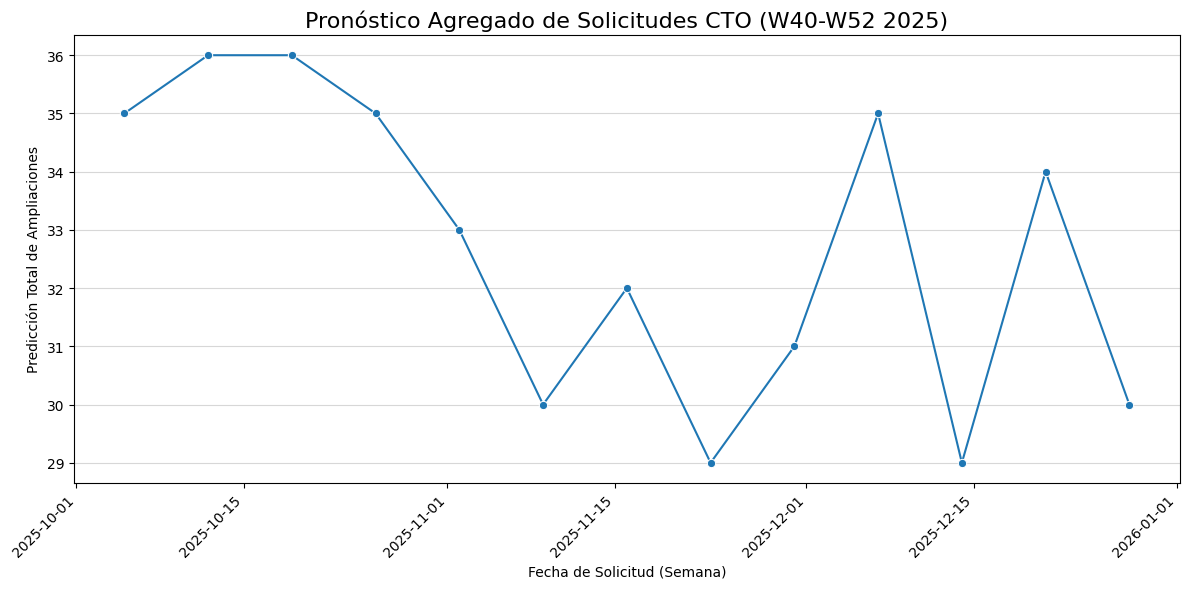

In [163]:
# 4. Visualización Final
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Agrupamos por semana y sumamos todas las provincias para ver la tendencia total
df_total_semanal = df_output.groupby('Fecha de solicitud')['Prediccion_Numero_Ampliaciones'].sum().reset_index()
sns.lineplot(data=df_total_semanal, x='Fecha de solicitud', y='Prediccion_Numero_Ampliaciones', marker='o')

plt.title('Pronóstico Agregado de Solicitudes CTO (W40-W52 2025)', fontsize=16)
plt.xlabel('Fecha de Solicitud (Semana)')
plt.ylabel('Predicción Total de Ampliaciones')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [164]:
nombre_archivo_total = 'pronostico_cto_total_semanal_W40_W52_2025.csv'
df_total_semanal.to_csv(nombre_archivo_total, index=False, decimal=',', sep=';')



In [165]:
archivo_original_df = 'xxx.csv'
df_modelo_final.to_csv(archivo_original_df, index=False, decimal=',', sep=';')

# MODELO RANDON FOREST

In [166]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [167]:
# Inicializar y Entrenar el Modelo
rf_model = RandomForestRegressor(
    n_estimators=500,        # Menos estimadores que LGBM es común
    max_depth=15,            # Limitamos la profundidad para prevenir overfitting
    random_state=42,         # Semilla para reproducibilidad
    n_jobs=-1,               # Usar todos los núcleos
    min_samples_split=10     # Aseguramos que los nodos tengan al menos 10 muestras
)

print("Entrenando Random Forest...")
rf_model.fit(X_train, y_train)
print("✅ Entrenamiento de Random Forest completado.")

Entrenando Random Forest...
✅ Entrenamiento de Random Forest completado.


In [168]:
# Evaluación
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_train[y_pred_rf_train < 0] = 0 
mse_rf = mean_squared_error(y_train, y_pred_rf_train)
rmse_rf = np.sqrt(mse_rf) 

print(f"Error RMSE (Random Forest) en el conjunto de entrenamiento: {rmse_rf:.2f}")

Error RMSE (Random Forest) en el conjunto de entrenamiento: 1.35


### Pronóstico con Random Forest

In [169]:
# --- Configuración del Bucle ---
df_rf_bucle = df_future_con_fecha.copy().reset_index(drop=True)
X_rf_modelo_bucle = df_rf_bucle[features].copy()
preds_rf_iterativas = []
TARGET = 'Numero_Ampliaciones'
LAG_COL_1 = f'{TARGET}_L1'
LAG_COL_4 = f'{TARGET}_L4'

# --- Bucle de Pronóstico con RF ---
for semana_idx in range(len(fechas_futuras)):
    
    fecha_actual = fechas_futuras[semana_idx]
    
    # 1. Obtener los índices de la semana actual
    filas_actuales_idx = df_rf_bucle[df_rf_bucle['Fecha de solicitud'] == fecha_actual].index
    
    # 2. Crear el input del modelo para esta semana
    X_pred_semana = X_rf_modelo_bucle.loc[filas_actuales_idx].copy()
    
    # 3. Predecir (Usamos rf_model)
    predicciones_semana = rf_model.predict(X_pred_semana)
    predicciones_semana = np.round(np.maximum(0, predicciones_semana)).astype(int)
    
    # 4. Guardar resultados
    df_pred_semana = df_rf_bucle.loc[filas_actuales_idx].copy()
    df_pred_semana[TARGET] = predicciones_semana
    preds_rf_iterativas.append(df_pred_semana)
    
    # 5. Actualizar Lags para la próxima semana (lógica idéntica al modelo anterior)
    if semana_idx + 1 < len(fechas_futuras):
        fecha_siguiente = fechas_futuras[semana_idx + 1]
        
        for index, row in df_pred_semana.iterrows():
            prov_id = row['Provincia_ID']
            pred_valor = row[TARGET]
            
            idx_siguiente = df_rf_bucle[
                (df_rf_bucle['Fecha de solicitud'] == fecha_siguiente) & 
                (df_rf_bucle['Provincia_ID'] == prov_id)
            ].index
            
            if not idx_siguiente.empty:
                 # Actualizar Lag 1
                 df_rf_bucle.loc[idx_siguiente, LAG_COL_1] = pred_valor
                 X_rf_modelo_bucle.loc[idx_siguiente, LAG_COL_1] = pred_valor 
                 
                 # Actualizar Lag 4
                 if semana_idx >= 3: 
                     preds_lag4 = preds_rf_iterativas[semana_idx - 3] 
                     pred_valor_lag4 = preds_lag4[preds_lag4['Provincia_ID'] == prov_id][TARGET].iloc[0]
                     
                     df_rf_bucle.loc[idx_siguiente, LAG_COL_4] = pred_valor_lag4
                     X_rf_modelo_bucle.loc[idx_siguiente, LAG_COL_4] = pred_valor_lag4

# 6. Concatenar y Formatear
df_rf_pronostico_final = pd.concat(preds_rf_iterativas).reset_index(drop=True)

# 7. Obtener nombres de provincia (reutiliza el 'mapeo_inverso' creado anteriormente)
df_rf_resultados = pd.merge(df_rf_pronostico_final, mapeo_inverso, on='Provincia_ID', how='left')

df_rf_output = df_rf_resultados[['Fecha de solicitud', 'Provincia', TARGET]].rename(
    columns={TARGET: 'Prediccion_Numero_Ampliaciones_RF'}
)
print("✅ Pronóstico de Random Forest Finalizado.")

✅ Pronóstico de Random Forest Finalizado.


### Visualización y comparación


--- Comparación de Pronósticos Semanales ---
  Fecha de solicitud    Provincia  Prediccion_Numero_Ampliaciones_LGBM  \
0         2025-10-05       TOLEDO                                    2   
1         2025-10-05  CIUDAD REAL                                    1   
2         2025-10-05       MADRID                                    2   
3         2025-10-05       CUENCA                                    1   
4         2025-10-05   VALLADOLID                                    1   

   Prediccion_Numero_Ampliaciones_RF  
0                                  2  
1                                  2  
2                                  2  
3                                  1  
4                                  1  


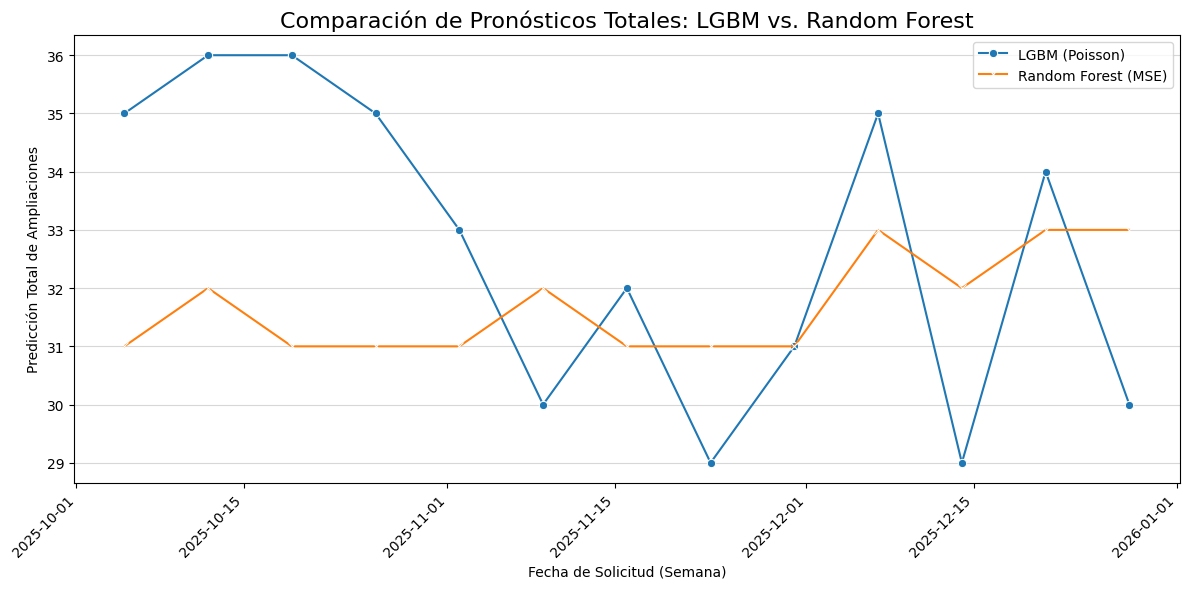

In [170]:
# 1. Renombrar la columna del modelo LightGBM para la fusión
df_output_lgbm = df_output.rename(
    columns={'Prediccion_Numero_Ampliaciones': 'Prediccion_Numero_Ampliaciones_LGBM'}
)

# 2. Fusionar los resultados de LGBM y RF
df_comparacion = pd.merge(
    df_output_lgbm, 
    df_rf_output, 
    on=['Fecha de solicitud', 'Provincia'], 
    how='inner'
)

print("\n--- Comparación de Pronósticos Semanales ---")
print(df_comparacion.head())

# 3. Visualización de la Comparación (Tendencia Total)
df_comp_total = df_comparacion.groupby('Fecha de solicitud').agg({
    'Prediccion_Numero_Ampliaciones_LGBM': 'sum',
    'Prediccion_Numero_Ampliaciones_RF': 'sum'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_comp_total, x='Fecha de solicitud', y='Prediccion_Numero_Ampliaciones_LGBM', label='LGBM (Poisson)', marker='o')
sns.lineplot(data=df_comp_total, x='Fecha de solicitud', y='Prediccion_Numero_Ampliaciones_RF', label='Random Forest (MSE)', marker='x')

plt.title('Comparación de Pronósticos Totales: LGBM vs. Random Forest', fontsize=16)
plt.xlabel('Fecha de Solicitud (Semana)')
plt.ylabel('Predicción Total de Ampliaciones')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [171]:
archivo_original_df = 'RForest.csv'
df_rf_output.to_csv(archivo_original_df, index=False, decimal=',', sep=';')